In [1]:
import json
from loguru import logger

# Data Prep

In [2]:
TRAIN_DATA = "data/rico_sca/rico_sca_test_sample_sample.json"

In [3]:
def prep_data(file_location):
        parsed_data = dict()
        logger.info("Preprocessing Rico SCA dataset")
        with open(file_location, "r") as f:
            input_data = json.load(f)

        number_of_screens = len(input_data)
        total_screen_elements = 0
        total_entries = 0
        largest = 0
        removed_entry = 0

        for _, screen_info in input_data.items():
            ui_elements_dict = dict()
            index_ui_element = 0

            total_screen_elements = (
                len(screen_info["ui_obj_str_seq"]) + total_screen_elements
            )
            for ui_element in screen_info["ui_obj_str_seq"]:

                ui_elements_dict[index_ui_element] = {
                    "text": ui_element,
                    "x0": screen_info["ui_obj_cord_x_seq"][index_ui_element * 2] * 1000,
                    "x1": screen_info["ui_obj_cord_x_seq"][(2 * index_ui_element) + 1]
                    * 1000,
                    "y0": screen_info["ui_obj_cord_y_seq"][index_ui_element * 2] * 1000,
                    "y1": screen_info["ui_obj_cord_y_seq"][(2 * index_ui_element) + 1]
                    * 1000,
                }
                index_ui_element = index_ui_element + 1

            index_instruction = 0
            for instruction in screen_info["instruction_str"]:
                selected_ui_element = screen_info["ui_target_id_seq"][index_instruction]
                if screen_info["instruction_rule_id"][index_instruction] == 1 or screen_info["instruction_rule_id"][index_instruction] == 2:
                    parsed_data[total_entries] = {
                        "instruction": instruction,
                        "ui": ui_elements_dict,
                        "label": selected_ui_element,
                    }

                    if len(screen_info["ui_obj_str_seq"]) > largest:
                        largest = len(screen_info["ui_obj_str_seq"])

                    total_entries = total_entries + 1

                index_instruction = index_instruction + 1

        logger.info(f"Largest index of selected UI element:{largest}")
        logger.info(f"Number of different screens: {number_of_screens}.")
        logger.info(f"Total Entries: {total_entries}")
        logger.info(f"Number of removed entries: {removed_entry}")

        return parsed_data, largest

In [4]:
dataset, largest = prep_data(TRAIN_DATA)

2021-01-13 10:04:19.093 | INFO     | __main__:prep_data:3 - Preprocessing Rico SCA dataset
2021-01-13 10:04:19.295 | INFO     | __main__:prep_data:50 - Largest index of selected UI element:53
2021-01-13 10:04:19.296 | INFO     | __main__:prep_data:51 - Number of different screens: 70.
2021-01-13 10:04:19.297 | INFO     | __main__:prep_data:52 - Total Entries: 391
2021-01-13 10:04:19.297 | INFO     | __main__:prep_data:53 - Number of removed entries: 0


### Get Embeddings for each UI Element

In [5]:
import pandas as pd
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, BertTokenizer, RobertaTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset
import torch

MODEL_NAME = "data/models/layoutlm-base-uncased"

In [6]:
def convert_ui_to_feature(
        example,
        max_seq_length,
        tokenizer,
        cls_token_at_end=False,
        cls_token="[CLS]",
        cls_token_segment_id=1,
        sep_token="[SEP]",
        sep_token_extra=False,
        pad_on_left=False,
        pad_token=0,
        cls_token_box=[0, 0, 0, 0],
        sep_token_box=[1000, 1000, 1000, 1000],
        pad_token_box=[0, 0, 0, 0],
        pad_token_segment_id=0,
        pad_token_label_id=-1,
        sequence_a_segment_id=0,
        mask_padding_with_zero=True,
    ):
        """ Loads a data file into a list of `InputBatch`s
            `cls_token_at_end` define the location of the CLS token:
                - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
                - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
            `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
        """

        box = [example["x0"], example["y0"], example["x1"], example["y1"]]
        tokens = tokenizer.tokenize(example["text"])
        token_boxes = [box] * len(tokens)
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

        tokens += [sep_token]
        token_boxes += [sep_token_box]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            token_boxes += [sep_token_box]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            token_boxes += [cls_token_box]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            token_boxes = [cls_token_box] + token_boxes
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = (
                [0 if mask_padding_with_zero else 1] * padding_length
            ) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            token_boxes = ([pad_token_box] * padding_length) + token_boxes
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            token_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(token_boxes) == max_seq_length

        features = {
            "input_ids": torch.LongTensor(input_ids).view(1,-1),
            "position_ids": torch.LongTensor(input_mask).view(1,-1),
            "token_type_ids": torch.LongTensor(segment_ids).view(1,-1),
            "bbox": torch.LongTensor(token_boxes).view(1,-1,4)

        }
        

        return features


In [7]:
layout_lm_config = AutoConfig.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME, config=layout_lm_config)


Some weights of the model checkpoint at data/models/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.x_position_embeddings.weight', 'bert.embeddings.y_position_embeddings.weight', 'bert.embeddings.h_position_embeddings.weight', 'bert.embeddings.w_position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.

Some weights of LayoutLMModel were not initialized from the model checkpoint at data/models/layoutlm-base-uncased and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.x_position_embeddings.weight', 'embeddings.y_position_embeddings.weight', 'embeddings.h_position_embeddings.weight', 'embeddings.w_position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.den

In [16]:
tokenizer_layout = AutoTokenizer.from_pretrained(MODEL_NAME)        
entries = dict()
for id_d, content in tqdm(dataset.items()):
    entries[id_d] = dict()
    for id_c, ui_element in content["ui"].items():
        encoded_ui = convert_ui_to_feature(ui_element, largest, tokenizer_layout)
        entries[id_d][id_c] = model(**encoded_ui)[1]
    break
        

        

    

### Visualizing the embedding

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")



In [11]:
for id_d, content in tqdm(entries.items()):
    input_emb = list()
    instructions = list()
    text_content = list()
    original_x = list()
    original_y = list()
    for id_c, ui_element in content.items():
        input_emb.append(ui_element.tolist()[0])
        text_content.append(dataset[id_d]["ui"][id_c]["text"])
        original_x.append(dataset[id_d]["ui"][id_c]["x0"])
        original_y.append(dataset[id_d]["ui"][id_c]["y0"])
        instructions.append(dataset[id_d]["instruction"])
        
    embs = tsne.fit_transform(input_emb)
    
    df = pd.DataFrame()
    df['x'] = embs[:, 0]
    df['y'] = embs[:, 1]
    df['original_x'] = original_x
    df['original_y'] = original_y
    df["text"] = text_content
    df["inst"] = instructions
    
    print(df)

             x           y  original_x  original_y                     text  \
0   166.422272 -328.975220   45.833334  148.437500                            
1    21.001556  440.812988  435.416669  832.031250                0 . 06 mb   
2  -315.506958   47.213257  815.972209  755.468726                 add page   
3   466.669525   92.790031    4.861111  868.749976                            
4   -62.631218 -125.630699  336.111098  868.749976                            
5   189.698395  -23.608255  863.888860  868.749976                            
6   251.338791  276.411499  174.999997   41.406251                 document   
7  -100.206558 -423.738770    0.000000   32.812499              navigate up   
8  -264.106934  325.509735  174.999997   74.609377          march 21 , 2017   
9   -24.820675  143.883820  883.333325   38.281251                    close   
10 -342.625977 -234.496140    0.000000  934.374988  navigationbarbackground   
11  423.978302 -211.758224    0.000000    0.000000  

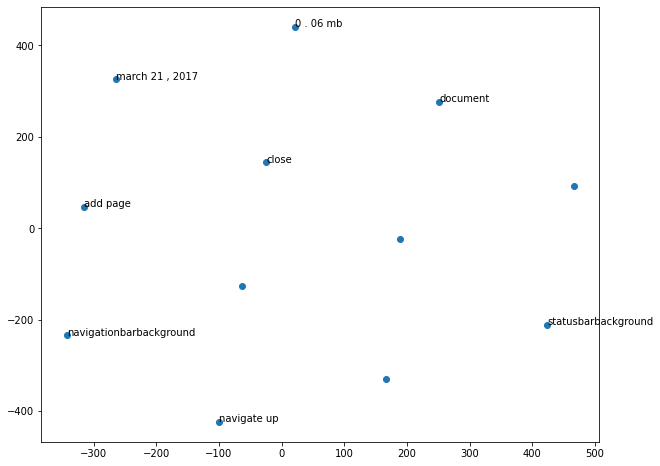

In [15]:

import matplotlib.pyplot as plt

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y);
for i, txt in df["text"].iteritems():
    ax.annotate(txt, (df.x[i], df.y[i]))

In [13]:
dataset[0]

{'instruction': 'select item at the top right corner',
 'ui': {0: {'text': '',
   'x0': 45.8333343,
   'x1': 954.1666508,
   'y0': 148.4375,
   'y1': 829.6874762000001},
  1: {'text': '0 . 06 mb',
   'x0': 435.4166687,
   'x1': 564.5833610999999,
   'y0': 832.03125,
   'y1': 857.8125237999999},
  2: {'text': 'add page',
   'x0': 815.972209,
   'x1': 990.9722209,
   'y0': 755.4687262000001,
   'y1': 868.7499762000001},
  3: {'text': '',
   'x0': 4.8611113,
   'x1': 140.9722269,
   'y0': 868.7499762000001,
   'y1': 934.3749881},
  4: {'text': '',
   'x0': 336.11109849999997,
   'x1': 668.0555343999999,
   'y0': 868.7499762000001,
   'y1': 934.3749881},
  5: {'text': '',
   'x0': 863.8888597,
   'x1': 1000.0,
   'y0': 868.7499762000001,
   'y1': 934.3749881},
  6: {'text': 'document',
   'x0': 174.99999699999998,
   'x1': 422.9166806,
   'y0': 41.406251499999996,
   'y1': 74.60937650000001},
  7: {'text': 'navigate up',
   'x0': 0.0,
   'x1': 136.1111104,
   'y0': 32.812498500000004,
   '